In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import GRU
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spei-data/TVF_SPEI_data/Fredtvf1.csv
/kaggle/input/spei-data/TVF_SPEI_data/Chartvf3.csv
/kaggle/input/spei-data/TVF_SPEI_data/Fredtvf3.csv
/kaggle/input/spei-data/TVF_SPEI_data/Chartvf12.csv
/kaggle/input/spei-data/TVF_SPEI_data/Chartvf1.csv
/kaggle/input/spei-data/TVF_SPEI_data/Chartvf6.csv
/kaggle/input/spei-data/TVF_SPEI_data/Fredtvf12.csv
/kaggle/input/spei-data/TVF_SPEI_data/Fredtvf6.csv


In [3]:
def metric(observed, simulated):

    numerator = np.sum((observed - np.mean(observed)) * (simulated - np.mean(simulated)))
    denominator = np.sqrt(np.sum((observed - np.mean(observed)) ** 2) * np.sum((simulated - np.mean(simulated)) ** 2))

    if denominator == 0:
        r = 0
    else:
        r = numerator / denominator

    rmse = np.sqrt(np.mean((observed - simulated) ** 2))

    nse = 1 - np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2)

    error = observed - simulated
    u95 = 1.96 * np.std(error)

    return {
        "R": r,
        "RMSE": rmse,
        "NSE": nse,
        "U95%": u95
    }

In [4]:
df = pd.read_csv('/kaggle/input/spei-data/TVF_SPEI_data/Fredtvf12.csv')
df

,IMF1(t-1),IMF1(t-2),IMF1(t-3),IMF2(t-1),IMF2(t-2),IMF2(t-3),IMF3(t-1),IMF3(t-2),IMF3(t-3),IMF4(t-1),...,IMF9(t-1),IMF9(t-2),IMF9(t-3),IMF10(t-1),IMF10(t-2),IMF10(t-3),IMF11(t-1),IMF11(t-2),IMF11(t-3),Tar
0,-0.377504,-0.232174,-0.151810,-0.116938,-0.114747,-0.093242,-0.078278,-0.053317,-0.048806,-0.014790,...,0.073770,0.088823,0.090561,0.091508,0.102224,0.170650,1.246865,1.289082,1.350828,2.464120
1,-0.232174,0.039947,0.091508,-0.101637,-0.116938,-0.114747,-0.058383,0.052979,0.051787,-0.006737,...,-0.152567,0.068049,-0.010272,0.073770,0.020569,0.090561,1.289082,1.350828,1.428907,2.252838
2,0.039947,0.295077,0.073770,-0.072515,-0.101637,-0.116938,0.047785,-0.050566,-0.053317,0.013250,...,0.054172,0.030193,-0.092194,-0.152567,-0.078278,-0.010272,1.350828,1.428907,1.519613,1.673735
3,0.295077,0.392288,-0.152567,-0.034578,-0.072515,-0.101637,0.081880,0.046120,0.052979,-0.002005,...,0.099274,-0.017334,-0.123231,0.054172,-0.058383,-0.092194,1.428907,1.519613,1.618881,1.618292
4,0.392288,0.273310,0.054172,0.006480,-0.034578,-0.072515,-0.008644,-0.039928,-0.050566,-0.011072,...,-0.123280,-0.065085,-0.093177,0.099274,0.047785,-0.123231,1.519613,1.618881,1.722426,1.798726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,-0.091283,0.095501,0.006709,0.163021,0.193994,0.203169,-0.007519,-0.025600,-0.015719,0.026401,...,0.009563,0.133634,-0.075866,-0.010624,-0.039868,-0.100708,-1.672571,-1.557117,-1.424170,0.066663
486,0.095501,0.214910,-0.010624,0.113555,0.163021,0.193994,0.081543,0.042775,0.017331,0.035268,...,-0.002949,0.167597,-0.016726,0.009563,-0.081549,-0.075866,-1.557117,-1.424170,-1.279187,-0.074100
487,0.214910,0.183654,0.009563,0.050998,0.113555,0.163021,0.057093,-0.065909,-0.025600,-0.036280,...,-0.005608,0.178531,0.050680,-0.002949,-0.007519,-0.016726,-1.424170,-1.279187,-1.127821,0.145124
488,0.183654,0.028697,-0.002949,-0.017732,0.050998,0.113555,-0.052006,0.086685,0.042775,-0.036272,...,0.010311,0.164387,0.096416,-0.005608,0.081543,0.050680,-1.279187,-1.127821,-0.975636,0.264244


In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(df)

In [6]:
X = df.drop('Tar', axis=1).values
y = df['Tar'].values

In [7]:
lookback_window = 20

def to_sequences(X, y, lookback_window):
    X_seq, y_seq = [], []
    for i in range(lookback_window, len(X)):
        X_seq.append(X[i - lookback_window:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = to_sequences(X, y, lookback_window)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [9]:
print("X_train :",X_train.shape,"y_train :",y_train.shape)

X_train : (376, 20, 33) y_train : (376,)


In [10]:
def rnnModel(input_shapes):
    model = Sequential()
    model.add(Input(input_shapes))

    model.add(SimpleRNN(units = 64, 
                            activation = "tanh",
                            return_sequences = True))
    
    model.add(SimpleRNN(units = 64, 
                            activation = "tanh",
                            return_sequences = True))
    
    model.add(SimpleRNN(units = 64,
                            activation = "tanh",
                            return_sequences = True))
    model.add( SimpleRNN(units = 64))
    
    model.add(Dense(units = 1,activation='sigmoid'))
    
    model.compile(optimizer = SGD(learning_rate=0.01,
                                      momentum=0.9), 
                      loss = "mean_squared_error")
    return model


model = rnnModel(input_shapes=(X_train.shape[1], X_train.shape[2]))
model.fit(X_train, y_train, epochs = 30, batch_size = 8)
model.summary()

Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.8582
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.8126
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.9248
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9001
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7727
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.8816
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7770
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.8288
Epoch 9/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.8793
Epoch 10/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7654
Epoch 11/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.8812
Epoch 12/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.8133
Epoch 13/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.8670
Epoch 14/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.8662
Epoch 15/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7678
Epoc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 20, 64)              │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 20, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 20, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,212 (243.02 KB)

 Trainable params: 31,105 (121.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 31,107 (121.52 KB)

In [11]:
y_pred_rnn = model.predict(X_test)
y_true = y_test.flatten()
y_pred_rnn = y_pred_rnn.flatten()


results = metric(y_true, y_pred_rnn)
print(results)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step
{'R': 0.1480523830425509, 'RMSE': 0.9844444990321636, 'NSE': -0.009176985489971035, 'U95%': 1.9200794325891297}


In [12]:
def gruModel(input_shapes):
    model = Sequential()
    model.add(Input(input_shapes))

    model.add(GRU(units=128, 
                         return_sequences=True,
                         activation='tanh'))
    
    model.add(GRU(units=128, 
                         activation='tanh'))
    
    model.add(Dense(units=1,
                           activation='relu'))
    
    model.compile(optimizer = SGD(learning_rate=0.001,
                                      momentum=0.9), 
                      loss = "mean_squared_error")
    return model


model = gruModel(input_shapes=(X_train.shape[1], X_train.shape[2]))
model.fit(X_train, y_train, epochs = 30, batch_size = 8)
model.summary()

Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.9180
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8244
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7848
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8194
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7832
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8224
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8256
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7772
Epoch 9/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.8841
Epoch 10/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8454
Epoch 11/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8271
Epoch 12/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8076
Epoch 13/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8198
Epoch 14/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7446
Epoch 15/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8217
Epoc

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 20, 128)             │          62,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,588 (1.23 MB)

 Trainable params: 161,793 (632.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 161,795 (632.02 KB)

In [13]:
y_pred_gru = model.predict(X_test)
y_pred_gru = y_pred_gru.flatten()
results = metric(y_true, y_pred_gru)
print(results)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step
{'R': 0.15126114007962888, 'RMSE': 0.9793560760000813, 'NSE': 0.0012285744988795866, 'U95%': 1.903198107016243}


In [14]:
def lstmModel(input_shapes):
    model = Sequential()
    model.add(Input(input_shapes))

    model.add(LSTM(64, 
             return_sequences = True))
    model.add(LSTM(64, 
                           return_sequences = False))
    model.add(Dense(1))
    
    model.add(Dense(1))
    
    model.compile(optimizer = SGD(learning_rate=0.01,
                                      momentum=0.9), 
                      loss = "mean_squared_error",
                       )
    return model


model = lstmModel(input_shapes=(X_train.shape[1], X_train.shape[2]))
model.fit(X_train, y_train, epochs = 30, batch_size = 8)
model.summary()

Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.8841
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7446
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7718
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7996
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7400
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6365
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6687
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7345
Epoch 9/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6626
Epoch 10/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7277
Epoch 11/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5789
Epoch 12/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6601
Epoch 13/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5875
Epoch 14/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6447
Epoch 15/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5746
Epoc

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 20, 64)              │          25,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,360 (454.54 KB)

 Trainable params: 58,179 (227.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,181 (227.27 KB)

In [15]:
y_pred_lstm = model.predict(X_test)
y_pred_lstm = y_pred_lstm.flatten()
results = metric(y_true, y_pred_lstm)
print(results)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step
{'R': 0.7087687801183724, 'RMSE': 0.6975343331441403, 'NSE': 0.4933406726198316, 'U95%': 1.3634297970623155}


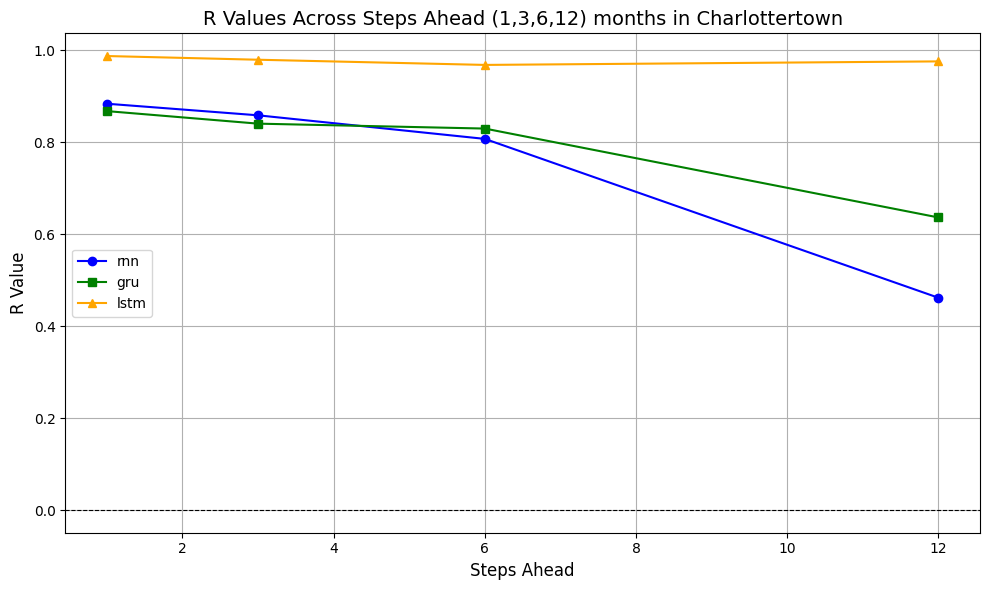

In [16]:
steps_ahead = [1, 3, 6, 12]
rnn = [0.883523, 0.858308, 0.807032, 0.461608]
gru = [0.867457, 0.840183, 0.829497, 0.636190]
lstm = [0.987212, 0.979172, 0.967892, 0.975557]

plt.figure(figsize=(10, 6))
plt.plot(steps_ahead, rnn, marker='o', label='rnn', linestyle='-', color='blue')
plt.plot(steps_ahead, gru, marker='s', label='gru', linestyle='-', color='green')
plt.plot(steps_ahead, lstm, marker='^', label='lstm', linestyle='-', color='orange')

plt.xlabel('Steps Ahead', fontsize=12)
plt.ylabel('R Value', fontsize=12)
plt.title('R Values Across Steps Ahead (1,3,6,12) months in Charlottertown', fontsize=14)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()

plt.show()

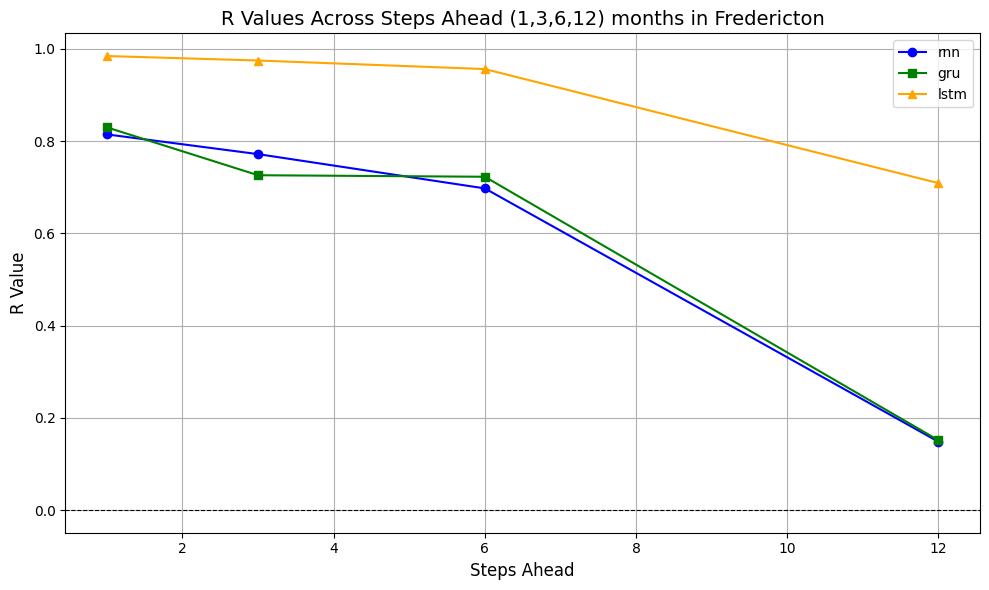

In [18]:
steps_ahead = [1, 3, 6, 12]
rnn = [0.814459, 0.771653, 0.697347, 0.148052]
gru = [0.829750, 0.725908, 0.722603, 0.151261]
lstm = [0.984345, 0.974647, 0.956095, 0.708769]

plt.figure(figsize=(10, 6))
plt.plot(steps_ahead, rnn, marker='o', label='rnn', linestyle='-', color='blue')
plt.plot(steps_ahead, gru, marker='s', label='gru', linestyle='-', color='green')
plt.plot(steps_ahead, lstm, marker='^', label='lstm', linestyle='-', color='orange')

plt.xlabel('Steps Ahead', fontsize=12)
plt.ylabel('R Value', fontsize=12)
plt.title('R Values Across Steps Ahead (1,3,6,12) months in Fredericton', fontsize=14)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()

plt.show()